In [97]:
import pandas as pd
pd.set_option("display.max_columns", None)

df = pd.read_csv("bench_convs.csv").dropna(axis=1)

mode_mapping = {
    0: "Row perforation",
    1: "Column perforation",
    2: "Filter sampling",
}

df["approx_info.mode_name"] = df["approx_info.mode"].map(lambda x:mode_mapping[x])

df["approx.total"] = df["approx.gemm"] + df["approx.im2col"] + df["approx.interpolate"] #+ df["approx.kn2row"]
df["normal.total"] = df["normal.gemm"] + df["normal.im2col"]
df["speedup"] = df["normal.total"] / df["approx.total"]
df["chw"] = df["info.c"] * df["info.h"] * df["info.w"]

# df.apply(lambda r:print(r), axis=1)

df["gemm.K"] = df["info.kh"]*df["info.kw"]*df["info.kn"] * \
    (1 - (df.apply(lambda r: 1/r["approx_info.perf_stride"]
     if r["approx_info.mode"] == 2 else 0, axis=1)))

df["gemm.N"] = df["info.w"]*df["info.h"] * \
    (1 - (df.apply(lambda r: 1/r["approx_info.perf_stride"]
     if r["approx_info.mode"] != 2 else 0, axis=1)))

df["gemm.M"] = df["info.kn"]

df


,info.n,info.c,info.h,info.w,info.kn,info.kh,info.kw,info.stride_h,info.stride_w,info.pad_h,info.pad_w,approx_info.mode,approx_info.perf_offset,approx_info.perf_stride,approx.gemm,approx.im2col,approx.interpolate,approx.kn2row,normal.gemm,normal.im2col,approx_info.mode_name,approx.total,normal.total,speedup,chw,gemm.K,gemm.N,gemm.M
0,16,16,8,8,16,1,1,1,1,1,1,1,0,2,3870976,287488,710912,0,7049728,408576,Column perforation,4869376,7458304,1.531676,1024,16.000000,32.000000,16
1,16,16,8,8,16,1,1,1,1,1,1,1,0,3,4003072,296192,701952,0,7049728,408576,Column perforation,5001216,7458304,1.491298,1024,16.000000,42.666667,16
2,16,16,8,8,16,1,1,1,1,1,1,1,0,4,5430016,292096,741376,0,7049728,408576,Column perforation,6463488,7458304,1.153913,1024,16.000000,48.000000,16
3,16,16,8,8,16,1,1,1,1,1,1,1,1,2,3950848,288000,737792,0,7049728,408576,Column perforation,4976640,7458304,1.498663,1024,16.000000,32.000000,16
4,16,16,8,8,16,1,1,1,1,1,1,1,1,3,5562368,312576,746496,0,7049728,408576,Column perforation,6621440,7458304,1.126387,1024,16.000000,42.666667,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,1,32,32,32,32,5,5,1,1,1,1,2,1,3,41124096,10325248,0,167936,60188672,1433600,Filter sampling,51449344,61622272,1.197727,32768,533.333333,1024.000000,32
1940,1,32,32,32,32,5,5,1,1,1,1,2,1,4,45713152,10210304,0,171520,60188672,1433600,Filter sampling,55923456,61622272,1.101904,32768,600.000000,1024.000000,32
1941,1,32,32,32,32,5,5,1,1,1,1,2,2,2,31593216,7687936,0,149504,60188672,1433600,Filter sampling,39281152,61622272,1.568749,32768,400.000000,1024.000000,32
1942,1,32,32,32,32,5,5,1,1,1,1,2,2,3,41267968,9781504,0,165376,60188672,1433600,Filter sampling,51049472,61622272,1.207109,32768,533.333333,1024.000000,32


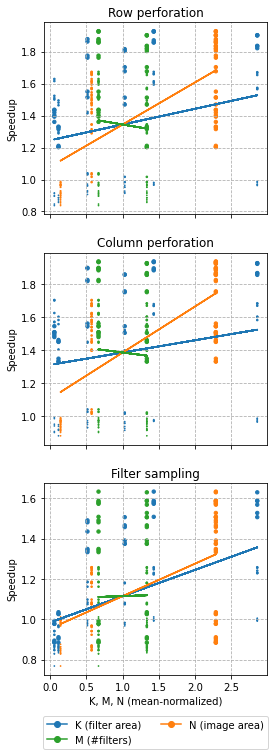

In [133]:
import matplotlib.pyplot as plt
import numpy as np


def get_coeff(x, y):
    from sklearn.linear_model import LinearRegression

    lr = LinearRegression()
    lr.fit(x[:, None], y)

    return lr.coef_, lr.intercept_

batch_size = 1
stride = 2

# Select convolutions with normal
sub = df.loc[(df["approx_info.perf_stride"] == stride) & (df["info.n"] == batch_size), :].copy()

sub["w*h"] = sub["info.w"] * sub["info.h"]
sub["w*h"] /= sub["w*h"].mean()


fig, axs = plt.subplots(3, 1, figsize=(4, 12), sharex=True)

axs_d = {mode_mapping[k]: axs[k] for k in mode_mapping}

ck = color = next(plt.gca()._get_lines.prop_cycler)['color']
cn = color = next(plt.gca()._get_lines.prop_cycler)['color']
cm = color = next(plt.gca()._get_lines.prop_cycler)['color']

for name, s in sub.groupby(["approx_info.mode_name"]):
    ax = axs_d[name]

    ax.set_title(f"{name}")

    sizes = np.power(s["w*h"]*4, 1.1)

    s.loc[:, "gemm.K"] /= s["gemm.K"].mean()
    s.loc[:, "gemm.N"] /= s["gemm.N"].mean()
    s.loc[:, "gemm.M"] /= s["gemm.M"].mean()

    coef_K, interc_K = get_coeff(s["gemm.K"].to_numpy(), s["speedup"].to_numpy())
    coef_N, interc_N = get_coeff(s["gemm.N"].to_numpy(), s["speedup"].to_numpy())
    coef_M, interc_M = get_coeff(s["gemm.M"].to_numpy(), s["speedup"].to_numpy())

    ax.plot(s["gemm.K"], s["gemm.K"]*coef_K+interc_K, c=ck)
    ax.scatter(s["gemm.K"], s["speedup"], s=sizes, c=ck)

    ax.plot(s["gemm.N"], s["gemm.N"]*coef_N+interc_N, c=cn)
    ax.scatter(s["gemm.N"], s["speedup"], s=sizes, c=cn)

    ax.plot(s["gemm.M"], s["gemm.M"]*coef_M+interc_M, c=cm)
    ax.scatter(s["gemm.M"], s["speedup"], s=sizes, c=cm)

    ax.plot([], [], 'o-', c=ck, label="K (filter area)")
    ax.plot([], [], 'o-', c=cm, label="M (#filters)")
    ax.plot([], [], 'o-', c=cn, label="N (image area)")

    ax.grid(ls="--")

    ax.set_ylabel("Speedup")

axs[-1].set_xlabel("K, M, N (mean-normalized)")
plt.legend(loc="center", bbox_to_anchor=(0.5, -0.3), ncol=2)
plt.savefig(f"conv-benchmark-n{batch_size}-s{stride}.pdf", bbox_inches='tight')
plt.show()
